<a href="https://colab.research.google.com/github/DomMcKean/DomMcKean.github.io/blob/main/tourch_seed_%3D_43_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google Drive
Allow Colab to access your Google Drive for saving models and other things. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
% reset -f
from __future__ import print_function
from __future__ import division
import torch
import torch.nn.functional as F
from torch import nn, optim
import sys
import os
import glob
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as plticker
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import random
import time
from datetime import datetime
from subprocess import call
import warnings
warnings.filterwarnings("ignore")


# Version Data
This block return Python, PyTorch and CUDA versions, plus, the number of GPUs available as well as any prosesses currently running. The gpu data can be copyed to elsewhere in the code, such as in the training loop to check gpu prosesses and memory usage. 

versions used here are:

    Python VERSION: 3.6.9 
    pyTorch VERSION: 1.5.1+cu101
    CUDA VERSION:
        Cuda compilation tools, release 10.1, V10.1.243
        CUDNN VERSION: 7603


In [3]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print('Available devices ', torch.cuda.device_count())
print('Current cuda device ', torch.cuda.current_device())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

__Python VERSION: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
__pyTorch VERSION: 1.7.0+cu101
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
Mon Jan  4 12:19:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================

Check CUDA is available

In [4]:
torch.cuda.is_available()

True



# Input Model Hyper-parameter settings
---
Here, one can stipulate the model number which is used to make a unique directory in your Google drive, along with sub-directories containing all the testing metrics. 

The hyper-parameters that can be changed here are:
<br>
<br>
**lr** = learning rate.
<br>
**fc** = number of fully connected layers bolted on to the back of the LSTM layers.
<br>
**path** = your desiered path to save and load models in Google Drive. 
<br>
**hidden** = number of hidden LSTM layers.
<br>
**epochs** = number of times to run through the whole training data.
<br>
**seq_length** = sequence length = the number of samples in each slice of a trajectory.
<br>
**feature_num** = number of features or independent variables in the data. 
<br>
<br>
Adjusting the number of features allows users to use a variable number of features or different types of data, such as joint data with 4 joints or Cartesian data with 6 Cartesian positions. 
<br>

The model automatically adjusts itself depending on the number of layers and features required. 

---




In [5]:
'''              ### MODEL HYPER-PARAMETER SETTINGS ###
-------------------------------------------------------------------------------
Here, the model hyper-parameters can be set, along with the save model path 
and the warm start model parameters path if using a pretrained model. 
'''
model_num  = '38'        ## Unique model number for saving new model.
model_dir  = 'model38'   ## New directory name to save new model to. 
random_seed = 0        ## Used to seed the random number generator for reproducibility.

params     = ''     ## Pretrained model params to load...
warm_start = False        ## ...and if to load them or not.
seq_length = 125          ## The length of the trajectory slice trained on.
traj_length = 500
epochs     = 101          ## Number of full passes through the whole dataset.
hidden     = 64         ## Number of nodes in the LSTM layers.
lstm_layers = 2
lr         = 0.005#0.0005       ## Learning rate.
feature_num   =  6        ## 4 features for joint data, 6 features for cartesian data.
fc         = 1           ## Number of fully connected layers. 1 or 2.
dropout = 0.5#0.5

## Remarks about this particular test.
notes = ("""  
            
""")

np.random.seed(random_seed)
torch.manual_seed(43) ## We should keep the same torch seed for the same weight initialisation.
path       = f"/content/drive/My Drive/PhD/PhD/lstm3/{model_dir}/" ## Save directory.

#------------------------------------------------------------------------------
## I increased the batch size and lr by 1 order.

## Functions to fetch hyper-parameters
def model_number():
    return model_num

def load_params():
    return params

def model_directory():
    return model_dir

def get_seq_length():
    return seq_length

def get_traj_length():
    return traj_length

def get_epochs():
    return epochs

def get_warm_start():
    return warm_start

def get_hidden():
    return hidden

def get_lr():
    return lr

def get_path():
    return path

def get_features():
    return feature_num

def get_fc():
    return fc

def get_lstm_layers():
    return lstm_layers

def get_random_seed():
    return random_seed

def get_dropout():
    return dropout

## Dictionary with which to save paramers.
param = {'Model Num':model_num, 
          'Seq Length': seq_length,
          'Epochs': epochs,
          'Warm Start': (warm_start),
          'Pretrained on': params,
          'Hidden Size': hidden,
          'Learning Rate': lr,
          'features': feature_num, 
          'Num LSTM Layers':lstm_layers,
          'Num FC Layers':fc,
          'Dropout': dropout,
          'Random Seed': random_seed,
          'Data/Notes': '''this dataset has no obstacles, it is a basic 
          exploreation of the taskspace for a simple RL controller project. .'''
}

## Create new directory in perent directory to save parameters.
try:
    os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed or already exists" % path)
else:
    print ("Successfully created the directory %s " % path)


## create a pandas data frame of the model parameters and save to csv.
param = pd.DataFrame(param, index=[0])
param.to_csv(path + "lstm_params.csv", index=False)


Successfully created the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/ 


# Testing Loop
---

This block fetches the testing data and passes it through the model after a set number of training runs.
<br>
For each trajectory in the training data, three metrics are obtained:
<br>
<br>
**MAE** = Mean Absolute Error accross each trajectory, measured in Newtons.
<br>
**RMSD** = Root Mean Sqared Deviation. Similar to MAE, but sensitive to outliers.
<br>
**COV** = Coefficient of Variance = RMSD/mean of the dataset. Useful for comparing performance across different models and datasets.
<br>
<br>
For each trained model, we find the **Grand Mean** or mean of means, **Standard Deviation** and **Max Value** over all the testing trajectories.
<br>

**PDF** or Probability Density Function and **Gaussian Distribution** plots of each metric are then created to give an intuative view of the metrics used.

---


In [6]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def tests(model_name):
    
    ## fetch parameters
    seq_len = get_seq_length()
    model_name = model_name
    model_dir = model_directory()
    path = get_path()
    features_num = get_features()

    
    ## Create new directory in perent directory
    path = path + f"{model_name}/"
    try:
        os.makedirs(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)

    stats_list = []
    pdf = PdfPages(path + f"testing_traj_pics_{model_name}.pdf")
    fig = plt.figure()

    
    #model = model.to(device)
    #print(model)
    #print("testing weights", model.linear1.weight.data) # Check weights are being updated.

    #model.reset_hidden_state()
    for traj in range(len(test_batches)):
        model.reset_hidden_state()
        whole_traj = []
        whole_true = []

        '''Although it is possible to feed in the entire trajectory and get
        the same prediction results, this cannot be done within the same model 
        instance, as the sequence length is fixed. 
        '''
        for start_seq in range(int(get_traj_length()/seq_length)): 
            start_seqx = start_seq*seq_length ## get the next sequence start position
            #model.reset_hidden_state()

            Xtest, ytest = get_test_batch(traj, start_seqx)
            model.eval()
            with torch.no_grad():
                
                x = iter(Xtest)
                test_seq = Xtest[0].reshape(-1,seq_len,features_num)#.reshape(1,200,4) # input first sequence from trajectory/batch
                preds = [] # create a list to store predictions.
                for i in range(len(Xtest)): # for each sequence i in the trajectory,
                    y_test_pred = model(test_seq).to(device)# send sequence to model,
                    pred = torch.flatten(y_test_pred).cpu() # reshape the model output,
                    preds.append(np.asarray(pred)) # and append to the list of predictions - preds.
                    new_seq = next(x).reshape(-1,seq_len,features_num)#.reshape(1,200,4) # Change sequence to the next one in the list.
                    test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_len, -1) # change sequence to a torch Tensor
                
            whole_traj.append(preds)
            whole_true.append(ytest)
        whole_true = np.array(whole_true).reshape(-1,)
        ## rescale the output predictions
        preds = target_scaler.inverse_transform(whole_traj).reshape(-1,3)
        ## Vector summation - the vector sum of the 3 output predictions
        force_vec = np.sqrt((preds[:,0]**2)+(preds[:,1]**2)+(preds[:,2]**2))
        
        ytest = whole_true
        preds = force_vec ## reset name to comply with existing code.
        #display(force_vec)
        
        #Mean Absolute Error
        MAE_list = []
        for i,j in zip(preds, ytest):
            error = np.abs(i-j)
            MAE_list.append(error)
        MAE = float("{:.3f}".format(np.mean(MAE_list)))
        #print("MAE","{:.3f}".format(MAE),'N')

        # Coefficient of Variance
        mean = np.mean(data.iloc[:,-1]) # mean of all dependent variables.
        cov_list = []
        for i,j in zip(preds, ytest):
            sq_dev = (i-j)**2
            cov_list.append(sq_dev)    
        MSD = np.mean(cov_list) # mean square deviation
        RMSD = np.sqrt(MSD) # root mean square deviation
        cov = RMSD/mean # coefficient of variance
        RMSD = float("{:.3f}".format(RMSD))
        cov =  float("{:.3f}".format(cov))
        #print("COV:","{:.3f}".format(cov))
        
    
        my_dict = {'Trajectory':traj,
                'MAE': MAE, 
                'RMSD':RMSD,
                'cov': cov, # Used to normalise the RMSD accross all the data
        }
        stats_list.append(my_dict)

        # Plot forces
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

        predicted_cases = preds
        true_cases = ytest
        # Add title and axis names
        
        
        from numpy.polynomial import Polynomial
        x = [i for i in range(get_traj_length())]
        y1 = predicted_cases
        p1 = Polynomial.fit(x, y1, 50)
        #plt.plot(*p1.linspace())

        #x = [i for i in range(250)]
        y2 = true_cases
        p2 = Polynomial.fit(x, y2, 50)

        #plt.plot(*p2.linspace())
        axes[0].plot(true_cases, color=lighten_color('b', 1.7), linewidth=3.0, label='True Force');
        axes[0].plot(predicted_cases, color=lighten_color('r', 1.0), linewidth=1.0, label='Predicted Force');
        axes[0].legend(loc=2, prop={'size': 12})
        axes[0].set_title(f'Force Trajectory {traj}');
        axes[0].set_xlabel('Sample num');
        axes[0].set_ylabel('Force (N)');
        axes[0].grid(True);
        axes[0].axis(ymin=0, ymax=110);

        #ymax = round(max(y2), 2)
        #x = list(np.linspace(0,249, num=1000))
        #xpos = x.index(ymax)
        #xmax = x[xpos]

        xmax = np.argmax(y2)
        ymax = y2.max()
        axes[0].annotate(f'Max True Force:\n {ymax:.2f}', xy=(xmax, ymax), xytext=(xmax-10, ymax+20),
            arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"));
        xmax = np.argmax(y1)
        ymax = y1.max()
        axes[0].annotate(f'Max Predicted Force:\n {ymax:.2f}', xy=(xmax, ymax), xytext=(xmax+5, ymax+5),
            arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"));

        ## create trajectory plot to save next to force plot.
        
        ## Realised that this code is not needed. Just plot everything in the robot's base frame!!!!
        # def base_to_task(batch):
        #     """
        #     Rotate a point counterclockwise by a given theta around a given origin.
        #     The theta should be given in radians.
        #     """
        #     #batch_numpy = batch.to_numpy()
        #     new_batch = []
            
        #     for row in batch:
                
        #         #print(batch)
        #         x = row[0] ## these were floats
        #         y = row[1]
        #         x+=	 0.28479# single 45 deg traj 0.42657	#original/old lab setup 0.05  #  make the offset first then rotate.
        #         y+=	 0.6536# -------------------0.54586	#original/------------  0.463
        #         theta = -0.0036# tried this one for obstales, didn't work!= -1.356  # original- seemed ok if EE faces same direction relative to robot.-0.215 # rotating clockwise from task to base frame.
        #         origin = 0,0
        #         point = x, y
        #         ox, oy = origin
        #         px, py = point
        #         qx = ox + np.cos(theta) * (px - ox) - np.sin(theta) * (py - oy)
        #         qy = oy + np.sin(theta) * (px - ox) + np.cos(theta) * (py - oy)

        #         new_batch.append([qx, qy])
                
        #     return np.array(new_batch)

        batch = test_batches[traj]
        trajectory = batch[['a', 'b']].to_numpy()## Hx and Hy are orifice position relative to the fixed zero position in the state space, not the robot's base frame. 
        #trajectory = base_to_task(new_batch)
        x = trajectory[:,0]
        y = trajectory[:,1]

        axes[1].set_title(f'Robot Trajectory {traj}');
        axes[1].set_xlabel('x(m)');
        axes[1].set_ylabel('y(m)');
        axes[1].grid(True);
        #axes[1].axis(xmin=-0.1,xmax=1.2);
        #axes[1].axis(ymin=-0.3,ymax=0.6);
        axes[1].annotate('Start', (x[0], y[0]), xytext=(x[0]+0.0, y[0]-0.2),arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"));
        axes[1].annotate('End', (x[-1], y[-1]), xytext=(x[-1]+0.02, y[-1]-0.2),arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"));
        axes[1].scatter(x, y, s=5); ## Scatter trajectory points

        Hx, Hy = [-0.33651, -0.60491]#trajectory[0,2], trajectory[0,3]
        axes[1].scatter(Hx, Hy, s=400, marker="s"); ## Orifice Marker
        axes[1].scatter(Hx, Hy, s=300, marker="o", c="k"); ## Orifice Marker
        axes[1].annotate(f'Orifice', (Hx, Hy), xytext=(Hx-0.1, Hy+0.05),arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"));

        try:
            #bob = batch[['O1x']].to_numpy()
            #if bob[0] == True:
            ## Obstacles
            first_obstacle = batch[['O1x', 'O1y']].to_numpy()
            #batch = #2nd obs [[0.00502, -0.57675]]  #1st obs [[-0.01049, -0.6805]]
            x1, y1 = first_obstacle[0,0],first_obstacle[0,1] #base_to_task(first_obstacle).flatten()
            axes[1].scatter(x1, y1, s=400, marker="s");
            axes[1].annotate(f'Obstacle 1', (x1, y1), xytext=(x1-0.1, y1+0.05),arrowprops = dict(  arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
            
            second_obstacle = batch[[ 'O2x', 'O2y']].to_numpy()
            x2, y2 =  second_obstacle[0,0], second_obstacle[0,1]
            #batch = #2nd obs [[0.19216, -0.57189]]  #[[0.18461, -0.55451]]
            #x2, y2 = base_to_task(second_obstacle).flatten()
            axes[1].scatter(x2,y2, s=400, marker="s");
            axes[1].annotate(f'Obstacle 2', (x2, y2), xytext=(x2-0.05, y2-0.05), arrowprops = dict(  arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
        except:
            pass
        

        #batch = [[0.60914, -0.54181]]
        x3, y3 = [0.26521, -0.66617]#[0.60914, -0.54181] #base_to_task(batch).flatten()
        axes[1].scatter(x3,y3, s=200, marker="X");
        axes[1].annotate('Goal', (x3, y3), xytext=(x3+0.14, y3+0.1), arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"));
        

        plt.figure(dpi=1200);
        fig.tight_layout();


        # save the current figure
        pdf.savefig(fig);
        # destroy the current figure
        plt.clf()

    pdf.close()
    stats_list = pd.DataFrame(stats_list)
    return stats_list

###############################################################################

def stats(stats_list2, model_name):
    
 
    ## Get the mean of MAE, RMSD and cov.
    mean_list = {
                'MAE' :float("{:.3f}".format(np.mean(stats_list2['MAE']))),
                'RMSD':float("{:.3f}".format(np.mean(stats_list2['RMSD']))),
                'cov' :float("{:.3f}".format(np.mean(stats_list2['cov'])))
    }
    ## Get the std-dev of MAE, RMSD and cov.
    std_dev = {
                'MAE' :float("{:.3f}".format(np.std(stats_list2['MAE']))),
                'RMSD':float("{:.3f}".format(np.std(stats_list2['RMSD']))),
                'cov' :float("{:.3f}".format(np.std(stats_list2['cov'])))
    }
    ## Get the max value of MAE, RMSD and cov.
    max_list = {
                'MAE' :float(stats_list2['MAE'].max()),
                'RMSD':float(stats_list2['RMSD'].max()),
                'cov' :float(stats_list2['cov'].max())
    }
    ## append above dicts to stats_list2.
    stats_list2 = stats_list2.append(mean_list, ignore_index=True).fillna('Grand Mean')
    stats_list2 = stats_list2.append(std_dev, ignore_index=True).fillna('Standard Dev')
    stats_list2 = stats_list2.append(max_list, ignore_index=True).fillna('Max Value')

    #display(stats_list2)
    path = get_path()
    
    ## Create new directory in perent directory
    path = path + f"{model_name}/"
    model_name = model_name

    ## save stats_list as .csv in same directory as trajectory plots.
    stats_list2.to_csv(path + f"lstm_model_metrics_{model_name}.csv", index=False)
    return stats_list2

###############################################################################

## Get a Gaussian Distribution of the MAE, RMSD and cov.
def gauss_plot(stats_list2, name, error_type, num):
    
    model_name = name
    model_dir = model_directory()
    path = get_path()
    path = path + f"{model_name}/"

    error = error_type ## Either; MAE, RMSD or cov.
    pdf = PdfPages(path + f"gauss_pic_{error}.pdf")
    fig = plt.figure()
    
    # define constants
    mu = np.mean(stats_list2.iloc[:-3,num]) 
    sigma = np.sqrt(np.var(stats_list2.iloc[:-3,num]))
    x1 = np.min(stats_list2.iloc[:-3,num])
    x2 = np.max(stats_list2.iloc[:-3,num])
    

    # calculate the z-transform
    z1 = ( x1 - mu ) / sigma
    z2 = ( x2 - mu ) / sigma

    x = np.arange(z1, z2, 0.001) # range of x in spec
    x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
    # mean = 0, stddev = 1, since Z-transform was calculated
    y = norm.pdf(x,0,1);
    y2 = norm.pdf(x_all,0,1);

    # build the plot
    fig, ax = plt.subplots(figsize=(9,6));
    #plt.style.use('fivethirtyeight');
    ax.plot(x_all,y2);

    ax.fill_between(x,y,0, alpha=0.3, color='b');
    ax.fill_between(x_all,y2,0, alpha=0.1);
    ax.set_xlim([-4,4]);
    ax.set_xlabel('# of Standard Deviations Outside the Mean');
    ax.set_yticklabels([]);
    ax.set_title(f'{model_name} {error} Std Dev');

    plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight');
    plt.grid(True);
    plt.tight_layout();
    #plt.show()
    # save the current figure
    pdf.savefig(fig);
    ## destroy the current figure
    plt.clf()

    # close the object
    pdf.close()

###############################################################################

## Get a PDF of the MAE, RMSD and cov.
def prob_dist(stats_list2, name, error_type, num):    
    model_name = name
    model_dir = model_directory()
    path = get_path()
    path = path + f"{model_name}/"


    error = error_type
    pdf = PdfPages(path + f"prob_dist_pic_{error}.pdf")
    fig = plt.figure()

    import seaborn as sns
    sns.distplot(stats_list2.iloc[:-3,num], color="darkslategrey");
    plt.xlabel("Force [newtons]", labelpad=14);
    plt.ylabel("Probability of Occurence", labelpad=14);
    plt.title(f"Probability Distribution of {error}", fontsize=20);
    plt.grid(True);
    plt.tight_layout();

    #plt.show()
    # save the current figure
    pdf.savefig(fig);
    # destroy the current figure
    plt.clf()
    plt.close('all') ## added this due to runtime warning, more than 20 figs open
    # close the object
    pdf.close()


In [7]:


# def func(i):
#     for row in i:
#         a = i[0]
#         b = i[1]
#         c = a+b
#     return c,c
# batch = [2.,4.]

# x,y = func(batch)
# print(x,y)

# def base_to_task(batch):
    
#     for row in batch:
        
#         print(batch)
#         x = row[0] 
#         y = row[1]
#         x+=	-28479
#         y+=	6536
#     return x,y
            
# batch = [[-0.01049, -0.6805]]
# x, y = base_to_task(batch)
# print(x,y)

# Test Controller
This block automates the execution of the testing code above by first calling tests() which generates the testing trajectory plots, but also calculates the MAE, RMSD and COV for each trajectory. The product of which is saved as a dictionary and returned.


In [8]:
def test_runner(name):   
    stats_df = tests(name) # Run tests on testing data and save generated plots to Google Drive
    stats(stats_df, name) # Record stats and save to Google Drive
    for i in range(1,4): # 1 to 3 = the colunms in the stats_list DataFrame
        if i ==1:
            error_type = 'MAE' # mean absolur error
        elif i == 2:
            error_type = 'RMSE' # root mean squared error
        elif i == 3:
            error_type = 'cov' # coefficient of variance

        prob_dist(stats_df, name, error_type, i) # Gen prob_dist and save to GD
        
        gauss_plot(stats_df, name, error_type, i) # Gen Gauss plots and save to GD
    print("Done")

# LSTM Network
---
The network consists of two LSTM layers with sixty nodes each, plus one fully connected output layer; however, these hyper-parameters can be adjusted in the hyper-parameter section above. The network is able to automatically adjust the number of LSTM layers, nodes and fully connected layers between one and three when stipulated in the hyper-parameter block. 
<br>
The reason for having adjustable fully connected layers here was because it was fount that the network could sometimes produce better models with more layers depending on the input data; however, the nature of the data has changed significantly since the start of this project, but it is still interesting to compare the performance when increasing the network complxity. 
<br>
A lot of experiments were carried out on all the available activation functions in PyTorch and 'Leaky relu' was found to perform the best for this task.

---

In [9]:
class ForcePredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2, ignore_zero=True):
        super(ForcePredictor, self).__init__()
        dropout = get_dropout()

        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            device = torch.device("cpu")
            print("Running on CPU")

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout= dropout)
        
        fc = get_fc() ## get num of FC layers


        if fc == 1:
            self.linear1 = nn.Linear(in_features=n_hidden, out_features=3)
            
        elif fc == 2:
            self.linear1 = nn.Linear(in_features=n_hidden, out_features=128)
            self.linear2 = nn.Linear(in_features=128, out_features=3)

        elif fc == 3:
            self.linear1 = nn.Linear(in_features=n_hidden, out_features=60)
            self.linear2 = nn.Linear(in_features=60, out_features=60)
            self.linear3 = nn.Linear(in_features=60, out_features=3)
        
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    ## Forward Function.
    
    def forward(self, sequences):

        '''                    ## Forward Method ##
        -----------------------------------------------------------------------
        This Method takes the input and passes it through each of the network 
        layers.
        ----------------------------------------------------------------------- 
        '''
        
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]

        y_pred = self.linear1(last_time_step)
        #y_pred = self.linear2(y_pred)
       
        #hidden = self.hidden
        return y_pred#, hidden

# Docstring Tester
---
This is just a little tester block to make sure the docstrings throughout the code are working as expected.

---

In [10]:
my_object = ForcePredictor(_,_,_)
print(my_object.forward.__doc__)

Running on the GPU
                    ## Forward Method ##
        -----------------------------------------------------------------------
        This Method takes the input and passes it through each of the network 
        layers.
        ----------------------------------------------------------------------- 
        


# Training Loop
---
This is where the magic happens!


In [11]:
def train_model(model):
    torch.manual_seed(42)
    path = get_path()
    '''                   ## training Loop ##
    ---------------------------------------------------------------------------

    ---------------------------------------------------------------------------
    '''
    lr = get_lr()
    loss_fn = torch.nn.MSELoss(reduction='mean')
    device = torch.device("cuda:0")
    loss_fn = loss_fn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#0.0007 
    print("learning rate =", lr) 
    num_epochs = get_epochs() #1600 #600
    path = get_path()
    seq_length = get_seq_length()

    #--------------------------------------------------------------------------
    '''                   ## Get Model Parameters ##
    ---------------------------------------------------------------------------
    If you want to restart training from an earlier model, first - it should be
    stipulated in the hyper-parameter setting at the beginning of the notebook
    by setting 'warm_start' = true, and adding the path to the saved model 
    location.


    '''
    start_epoch = 0
    warm_start = get_warm_start()
    if warm_start == True:      
        params = load_params() # model num and version num: 4_v100.
        PATH = path + f"/model_params{params}.pt"     
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
        start_epoch = checkpoint['epoch']
        loss_fn = checkpoint['loss']
        loss_fn = loss_fn.to(device)

    model = model.to(device)

    print(model)
    print("Starting Weights", model.linear1.weight.data) # Check weights are being updated.
    start_weights = model.linear1.weight.data.clone()

    ## create new lists to save the losses over the whole training phase.
    tot_losses = []
    tot_test_losses = []

    ## Set time with which to reference elapsed time.
    s1 = time.strftime('%H:%M:%S')

    '''                   ## Start of Training Loop
    ---------------------------------------------------------------------------
    start_epoch = 0 unless using pre-trained model.
    num_epochs is stipulated in model hyper-parameter settings.
    
    '''

    for t in range(start_epoch, num_epochs):

        tot_traj_losses = [] ## empty total trajectory losses list
        tot_traj_test_losses = []    

        for j in range(len(batches)): #-----------------------------------------## for each traj in training data.
            if t % 5 != 0: 
                ## Get current epoch, batch num and elasped time.
                s2 = time.strftime('%H:%M:%S')
                FMT = '%H:%M:%S'
                tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
                print("\r", f"Epoch:{t} Traj:{j}",
                      " Time Elapsed:", tdelta, end="") #-----------------------## print epoch & batch for a visual reference during training. 
                if j == 160:
                    print()
            model.reset_hidden_state() #----------------------------------------## reset hidden state for the start of each trajectory
            losses = [] #-------------------------------------------------------## reset sum of losses for each trajectoy. 

            ''' Fetch n samples from each trajectory to train on before updatining network.'''
            for start_seq in range(int(get_traj_length()/seq_length)): #---------------------## 1000 samples divided by seq length returns num slices.
                train_data, train_labels, _, _ = get_batches(j, start_seq*seq_length) ## dataloader- featch each slice of the traj at a time.
                torch.autograd.set_detect_anomaly(True)
                model.reset_hidden_state() #----------------------------------------## reset hidden state for the start of each trajectory

                optimizer.zero_grad() #----------------------------------------## moved zerograd to start of each trajectory. ### having zero_grad here produces strange peaks at start of trajectory
                y_pred = model(train_data) #------------------------------------## make prediction on a slice/batch.
                loss = loss_fn(y_pred.float(), train_labels) #------------------## loss for each slice/batch.
                losses.append(loss.item()) #------------------------------------## append for all slices/batches == 1 trajectory.
                loss.backward(retain_graph=True) #-----------------------------------------------## Calculate the gradients of the loss wrt the network weights.
                optimizer.step() #----------------------------------------------## Update network weights.
            traj_loss = np.mean(losses) #---------------------------------------## average loss over each trajectory
            

            model.reset_hidden_state() #----------------------------------------# Seperate training and testing hidden states. 
            test_losses = []
            for start_seq in range(int(get_traj_length()/seq_length)): 

                #start_seqx = start_seq*seq_length ## get the next sequence start position
                _, _, test_data, test_labels = get_batches(j, start_seq*seq_length)
                with torch.no_grad():
                    y_test_pred = model(test_data)
                    test_loss = loss_fn(y_test_pred.float(), test_labels) ## loss for each test trajectory slice.
                test_losses.append(test_loss.item()) ## append loss for each trajectory slice.
            traj_test_loss = np.mean(test_losses) ## average test loss over each tarjectory of n samples

            '''MSE Loss reporting. Uncomment to see printout of loss during training.
            '''
                ## The loss will look small (<1) but that's because we are not de-scaling the output. 
            if t % 5 == 0:
                 
                s2 = time.strftime('%H:%M:%S')
                FMT = '%H:%M:%S'
                tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
                print(f'Epoch: {t} Traj:{j}', 'Time Elapsed:', tdelta,  f'train loss: {traj_loss} test loss: {traj_test_loss}') ## display losses for each trajectory every 10 epochs.

            '''
            Traj_loss is the mean of the loss over a single trajectory. 
            Here we append these mean losses to a list of mean losses for the whole epoch.
            '''   
            tot_traj_losses.append(traj_loss) ## save each trajectory loss over each epoch.
            tot_traj_test_losses.append(traj_test_loss) 

        ## Periodically save model and show training and testing loss
        if t % 1 == 0:
            print('\n Saving model', '\n')

            save_path = path + "params_folder"
            try:
                os.makedirs(save_path)
            except OSError:
                print (f"Creation of the directory {save_path} failed" )
            else:
                print (f"Successfully created the directory {save_path}" )


            model_num = model_number()
            model_save_name = f'/model_params{model_num}_v{t}.pt'
            torch.save({
                'epoch': num_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss':loss,},
                save_path + f"{model_save_name}" 
            )
            print("Save path =", save_path + f"{model_save_name}")


            mean_loss = np.mean(tot_traj_losses) ## get the mean of the traj losses for each epoch.
            mean_test_loss = np.mean(tot_traj_test_losses)
            print("\n Average Loss")
            print(mean_loss)
            print("\n Average Test Loss")
            print(mean_test_loss,'\n')
            diff = mean_test_loss - mean_loss
            print("Difference Between Training and Testing Losses")
            print(diff.item(),'\n')
            tot_losses.append(mean_loss)
            tot_test_losses.append(mean_test_loss)
        

            name = f'model{model_num}_v{t}'
            test_runner(name)
            model.train() ## just in case it was left in .eval() mode.

            model_dir = model_directory()

            pdf = PdfPages(path + "/loss.pdf")
            fig = plt.figure();

            '''
            Plot the mean training and testing losses over each epoch.
            '''
            if t !=0:
                min_loss = round(min(tot_losses),3), ' @ epoch: ', np.argmin(tot_losses)
                min_test_loss = round(min(tot_test_losses),3), ' @ epoch: ', np.argmin(tot_test_losses)

                plt.plot(tot_losses, label=f'Training Loss: Min Value={min_loss[0]}{min_loss[1]}{min_loss[2]}'); 
                plt.plot(tot_test_losses, label=f'Testing Loss: Min Value={min_test_loss[0]}{min_test_loss[1]}{min_test_loss[2]}'); 
                plt.xlabel("Epochs", labelpad=14);
                plt.ylabel("MSE Loss", labelpad=14);
                plt.title(f"Training and Testing Losses {model_dir}", fontsize=20);
                #tick_labels = [i for i in range(100)]
                plt.xticks(np.arange(0,101, 10));
                plt.grid(True);
                plt.tight_layout();
                plt.legend();

                # save the current figure
                pdf.savefig(fig);

                figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
                plt.show()
                plt.pause(0.01)

                # destroy the current figure
                plt.clf()
                # close the object
                pdf.close()

        losses = []
        test_losses = []


# Import Data
---
This section did automatically selects which dataset to download based on the feature number selection made at the start. 
<br>
However, it was descovered that the model can in fact utilise two or more cleaned datasets, picking feature columns as necessary, assuming the datasets are of the same original raw data.
<br>
For example, The Cartesian feature model uses the X, Y, Z, Rx, ry and Rz features of the Cartesian dataset, together with the Fx, Fy and Fz target features of the joints dataset.
<br>
Of course, these datasets could be combined and a lot of processed datasets based on the original raw data have been created and added to the gitbub repositiory; however, i think it's interesting to see how different datasets can be combined.
<br>
4 features for the joint data and 6 features for the Cartesian data. 

---

In [12]:
## Get num
feature_num = get_features()
url = 'https://raw.githubusercontent.com/PorkPy/DLO_manipulation_LSTM/PorkPy-data_for_RL/all_data.csv'

#url2 = 'https://raw.githubusercontent.com/PorkPy/LSTM-Force-Predictor/master/80k_data/4_joints_3_force_1_forceVec.csv'

#url3 = 'https://raw.githubusercontent.com/PorkPy/LSTM-Force-Predictor/master/80k_data/mean_force_data.csv'


data = pd.read_csv(url)

#data2 = pd.read_csv(url2)
#data3 = pd.read_csv(url3)
main_seq = data

In [13]:
display(data.head())
print(data.columns)
print(len(data))

,rosbagTimestamp,Fx,Fy,Fz,Tx,Ty,Tz,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5,vel_joint_0,vel_joint_1,vel_joint_2,vel_joint_3,vel_joint_4,vel_joint_5,effot_joint_0,effot_joint_1,effot_joint_2,effot_joint_3,effot_joint_4,effot_joint_5,Force Vec,Torque Vec,x,y,z,Rx,Ry,Rz
0,1.607963e+09,0.789993,-0.830002,-0.080000,0.041,0.209000,0.051,0.888099,-0.920875,2.064452,-2.715451,4.710296,2.263148,0.000000,0.000000,-0.000000,0.000000,0.0,0.0000,-1.071167,-6.248475,-1.605136,-0.538330,0.251221,-0.029160,1.148648,0.219004,-0.329250,-0.664467,0.001595,3.141109,0.002303,0.195746
1,1.607963e+09,0.829987,-0.809998,-0.039999,0.038,0.212000,0.051,0.888087,-0.920923,2.064440,-2.715451,4.710308,2.263136,0.000000,0.000000,-0.000000,0.000000,0.0,0.0000,-1.107788,-6.188965,-1.605136,-0.520386,0.246735,-0.022430,1.160420,0.221335,-0.329265,-0.664474,0.001634,3.141162,0.002331,0.195746
2,1.607963e+09,0.829987,-0.840012,-0.049999,0.038,0.209000,0.052,0.888135,-0.920875,2.064488,-2.715451,4.710320,2.263124,0.000000,0.000000,-0.000000,0.000000,0.0,0.0000,-1.103211,-6.230164,-1.596169,-0.567490,0.246735,-0.031403,1.181946,0.218698,-0.329210,-0.664464,0.001582,3.141096,0.002262,0.195806
3,1.607963e+09,0.689987,-0.130005,-0.090000,-0.001,0.205999,0.051,0.888087,-0.920899,2.064476,-2.715487,4.710320,2.263148,0.000000,0.000000,-0.000000,0.000000,0.0,0.0000,-1.098633,-6.211854,-1.611862,-0.488983,0.246735,-0.017944,0.707873,0.212221,-0.329251,-0.664458,0.001608,3.141152,0.002307,0.195734
4,1.607963e+09,-0.050003,-3.100006,-0.719999,0.331,0.087000,0.018,0.889407,-0.920492,2.063720,-2.714433,4.710248,2.267565,0.013307,0.000639,0.004321,-0.000345,0.0,0.0423,0.924683,-5.314637,-1.925715,-0.554031,-0.013458,0.352158,3.182913,0.342716,-0.328578,-0.665133,0.001458,3.140562,0.001918,0.192636


Index(['rosbagTimestamp', 'Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz', 'joint_0',
       'joint_1', 'joint_2', 'joint_3', 'joint_4', 'joint_5', 'vel_joint_0',
       'vel_joint_1', 'vel_joint_2', 'vel_joint_3', 'vel_joint_4',
       'vel_joint_5', 'effot_joint_0', 'effot_joint_1', 'effot_joint_2',
       'effot_joint_3', 'effot_joint_4', 'effot_joint_5', 'Force Vec',
       'Torque Vec', 'x', 'y', 'z', 'Rx', 'Ry', 'Rz'],
      dtype='object')
25000


# Data Selection and Scaling
---
This block selects the desired features and targets from the datasets above and scales each section. The features and targets are scaled individually so that the output from the model can be de-scaled easily. 

---

In [14]:
xy = data[['x', 'y']]
#obs_pos = data[['Hx']]
#obs_pos2 = data[['Hx','Hy', 'O1x', 'O1y', 'O2x', 'O2y']]

features = data[['x', 'y', 'z', 'Rx', 'Ry', 'Rz']]
feature_scaler = StandardScaler()
features = feature_scaler.fit_transform(features)

targets = data[['Fx', 'Fy', 'Fz']]
target_scaler = StandardScaler()
targets = target_scaler.fit_transform(targets)

force_vec = pd.DataFrame(data[['Force Vec']])


#obs_pos = pd.DataFrame(obs_pos)
features = pd.DataFrame(features)
targets = pd.DataFrame(targets)
data = pd.concat([targets, features, force_vec, xy ], axis=1)
data.columns = [['Fx','Fy','Fz','x','y','z','Rx','Ry','Rz','force vec','a','b']]
display(data)
print(data.columns)

,Fx,Fy,Fz,x,y,z,Rx,Ry,Rz,force vec,a,b
0,0.411985,0.579808,0.252419,-1.385208,0.960773,0.108507,0.537770,-0.633334,-1.345504,1.148648,-0.329250,-0.664467
1,0.426945,0.580859,0.262170,-1.385286,0.960719,0.120667,0.537790,-0.631847,-1.345504,1.160420,-0.329265,-0.664474
2,0.426945,0.579282,0.259732,-1.385012,0.960802,0.104539,0.537765,-0.635479,-1.345389,1.181946,-0.329210,-0.664464
3,0.374575,0.616587,0.249981,-1.385214,0.960841,0.112599,0.537786,-0.633101,-1.345526,0.707873,-0.329251,-0.664458
4,0.097761,0.460539,0.096403,-1.381857,0.955682,0.065470,0.537560,-0.653431,-1.351449,3.182913,-0.328578,-0.665133
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.044384,0.693299,0.991055,1.821687,0.718936,0.397160,-1.873936,-0.476812,1.034967,3.264399,0.313977,-0.696084
24996,-0.014463,0.696451,0.991055,1.821621,0.719047,0.400886,-1.873940,-0.476066,1.034990,3.279803,0.313964,-0.696070
24997,-0.018201,0.691197,0.988617,1.821637,0.719055,0.398502,-1.873943,-0.477910,1.034967,3.230677,0.313967,-0.696069
24998,0.022947,0.690671,0.993492,1.821530,0.719041,0.395202,-1.873940,-0.476059,1.034967,3.234577,0.313946,-0.696071


MultiIndex([(       'Fx',),
            (       'Fy',),
            (       'Fz',),
            (        'x',),
            (        'y',),
            (        'z',),
            (       'Rx',),
            (       'Ry',),
            (       'Rz',),
            ('force vec',),
            (        'a',),
            (        'b',)],
           )


In [15]:
# print(data.columns)
# print(data.get((      'Hx2',)))
# data.loc[: , (      'Hx2',)]
# data[(      'Hx2',)].replace(-0.28479, 0, inplace=True)
# data[(      'Hx2',)].replace(-0.6069399999999999, 1, inplace=True)#, -0.51395: 1}}) #399999999999
# #data.replace(-0.65360, 0, inplace=True)
# #data.replace(-0.51395, 1, inplace=True)

# display(data)
# a = data.iloc[26245, 9]
# b = data.iloc[26245, 10]

# print(a,b)


# Create Training and Testing Data Batches
---
This block takes the whole dataset and divides it up into individual trajectories that are 1000 samples each.
<br>
As the data were collected by performing different kineasthetic trajectories through the taskspace, and each trajectory was performed ten times; the trajectories are shuffled to remove corrolations between them. 
<br>
Later, you will see how the trajectories themselves are further split into slices, and the model is trained on one slice at a time. Typical slice sizes have been 500, 250 and 125.
<br>
Because of this extra slicing, one may ask; why not just divide the dataset into 500, 250 or 125 sample trajectories to begine with?
<br>
We need to shuffle the trajectories to break up any corrolation between them, but doing this to all the slices would destroy the collolarion between slices belonging to a each trajectory. 
<br>
Every batch of slices needs to be kelpt together during traing because they are still used as full trajectories by the model during training by not resetting the hidden states of the LSTM layers until all slices of a particular trajectory have been seen. 
<br>
This means, that although the model has its parameters updated after seeing each slice, the history of previous slices still influence the training until the full trajectoy has passed through and the hidden states get reset.
<br><br>
Due to the current size of the dataset, The training set consists of sixty trajectories.
<br>
This leave a remander of eleven trajectories to test with; therefore, testing and validation sets use the same eleven trajectories; however,
in order to compare training and testing loss as the model learns, the number of testing trajectory is inflated by copying them until they are the same length.
<br>
To overcome the problem of such a small testing set, cross validation is used to compare models and get an average loss overall. 
The cross validation is simply initiated by changing the random seed at the beginning of the notebook which reshuffels the data, resulting in largly different training and testing trajectories. 


---

In [16]:
n= get_traj_length()  ## num samples per trajectory/sequence.
batchesx = [data[i:i + n] for i in range(0, len(data), n)] ## a list comprehension to build the data batches.
print(len(batchesx))


'''for i in batchesx:
    i[:20] = 0''' ## no longer needed as we don't use the rolling average on force vector. 

#display(batchesx[59].head(25))

random.seed(get_random_seed())
random.shuffle(batchesx)


batches = batchesx[:40] ## Training batches up to the 60th sequence/trajectory.
val_batches = batchesx[40:50] ## Validation batches starting from the 60th sequence.

## Append extra validation batches to even the number training and validation batches.
## This is because the training loop performs a validation test on each iteration
## and so always needs something to validate against.  
while len(val_batches) < len(batches): 
    for i in batchesx[40:50]:
        val_batches.append(i)
random.shuffle(val_batches)

test_batches = batchesx[40:50] ## Testing batches, same as validation batches, without the appendages.
print(len(batches), len(val_batches), len(test_batches))

## the last 30 trajectories are held back for unseen validation. Once there is no more tweeking done to the model. 

50
40 40 10


In [17]:
display(batches[0].head())


,Fx,Fy,Fz,x,y,z,Rx,Ry,Rz,force vec,a,b
21500,0.576579,0.554063,0.822851,-1.334155,0.308265,-1.343758,0.532621,-0.876847,-1.083520,2.891871,-0.319010,-0.749774
21501,0.606506,0.562470,0.820413,-1.334206,0.308197,-1.341195,0.532617,-0.874925,-1.083611,2.850299,-0.319020,-0.749783
21502,0.565358,0.564046,0.830164,-1.334315,0.308070,-1.333280,0.532638,-0.873700,-1.083566,2.821526,-0.319042,-0.749799
21503,0.595284,0.558266,0.815537,-1.334234,0.308424,-1.341148,0.532604,-0.874625,-1.083588,2.854629,-0.319026,-0.749753
21504,0.569102,0.551436,0.800911,-1.334141,0.308358,-1.338588,0.532606,-0.875114,-1.080543,2.837237,-0.319007,-0.749762


# Create Sequence Batches
---
It turns out that this sequencial data problem is more similar to natural language processing rather than stock pridiction because we have set sequences of data rather than continuous data, and because we need to make predictions righ from the start of each sequence not just at the end of them.

---

<br>
Natural language prosessing or nlp, has the problem of needing to input sequences of differing lengths (because words and sentences have different lengths) into an recurrant network that only accepts fixed length vectors. 
<br>
To Overcome this, npl engineers use 'zero padding' which fills up a word or sentence vector with zeros until it is the correct size for the network. 
<br>
This work is a little different but the zero padding technique helps a lot but allowing use to input every timestep of a trajectory from beginning to end while making predictions on every one. 
<br>
To makes things a little mopre clear- the first datapoint of a trajectory is just that, one single datapoint, a sequence consisting of one timestep, but the final datapoint is part of a sequence containing a history of the previous 999 timesteps. 
<br>
In order to fit these and all the other datapoints into the network,
they need to be zeropadded to length 1000.
The first sequence to be fed through the network will consist of one single datapoint and '999*num_features' zeros. 
<br>
This means, that despite only having one single datapoint at the beginning of the trajectory, our LSTM-based model can still make a valid prediction of the force at that point.  

---

In [18]:
def get_batches(batch_num, start_seq):  
    
    seq_size = get_seq_length() # 1000 = full trajectories
    features_num = get_features()

    # random.seed(batch_num)
    # random.shuffle(batches) # ive turned this off to test new cleaned data

    # Randomise the fetching of new data to break the corrolation of training.
    #print(batch_num)
    #print(type(batches[batch_num])) 
    data = batches[batch_num].reset_index(drop=True)
    data= data[start_seq:seq_size+start_seq]
    ################################################

    X_train = []
    X_test = []
    
    if features_num == 4:
        features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    else:
        features = data[['x', 'y', 'z', 'Rx', 'Ry', 'Rz']]#,'Hz', 'HRz', 'O1x', 'O1y', 'O2x', 'O2y']]
    features = np.asarray(features)


    targets = data.iloc[:,:3]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,3)

    ## Create Zero-Padded Training Batches ##
    for i in range(len(features)):           
        
        np.random.seed(42)
       
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, features_num))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_train.append(temp)
    y_train = targets
    #--------------------------------------------------------------------------
    
    ## Validation Batches
    data = val_batches[batch_num].reset_index(drop=True)
    data= data[start_seq:seq_size+start_seq]

    if features_num == 4:
        features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    else:
        features = data[['x', 'y', 'z', 'Rx', 'Ry', 'Rz']]#,'Hz', 'HRz', 'O1x', 'O1y', 'O2x', 'O2y',]]
    features = np.asarray(features)


    targets = data.iloc[:,:3]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,3)
    
    for i in range(len(features)):           
   
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, features_num))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_test.append(temp)
    y_test = targets
##############################################################################
    ## Change data to cuda tensors to use on gpu.
    X_train = torch.cuda.FloatTensor(X_train) 
    y_train = torch.cuda.FloatTensor(y_train)
    X_test = torch.cuda.FloatTensor(X_test)
    y_test = torch.cuda.FloatTensor(y_test)
    
    del targets, features, data ## clear large volumn variables from mem
    
    #print(data)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return(X_train, y_train, X_test, y_test)

# Test Batches
---



In [19]:
def get_test_batch(batch_number, start_seq):
    
    seq_size = get_seq_length() ## 1000 for testing 50-100 for training
    features_num = get_features()

    X_test = []

    data = test_batches[batch_number].reset_index(drop=True)
    data= data[start_seq:seq_size+start_seq]

    if features_num == 4:
        features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    else:
        features = data[['x', 'y', 'z', 'Rx', 'Ry', 'Rz']]#,'Hz', 'HRz', 'O1x', 'O1y', 'O2x', 'O2y',]]
    features = np.asarray(features)
    y_test = data.iloc[:,9]
    
    for i in range(len(features)):           
   
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, features_num))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_test.append(temp)

    
    X_test = torch.cuda.FloatTensor(X_test)
    return(X_test, y_test)
  

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")


Running on the GPU


Running on the GPU
learning rate = 0.005
ForcePredictor(
  (lstm): LSTM(6, 64, num_layers=2, dropout=0.5)
  (linear1): Linear(in_features=64, out_features=3, bias=True)
)
Starting Weights tensor([[ 0.1018, -0.0686, -0.0514,  0.0751, -0.0798,  0.0332,  0.0337,  0.0866,
          0.0564, -0.0441,  0.1148, -0.0416,  0.0671, -0.0179,  0.0908, -0.0186,
          0.0492, -0.0900,  0.0584, -0.0058, -0.0209, -0.0617,  0.0073,  0.0795,
          0.1113,  0.0049, -0.0771, -0.0716,  0.1181, -0.1114, -0.0450,  0.0730,
         -0.0235, -0.0455, -0.0292,  0.0111, -0.0561,  0.0925, -0.1179, -0.1063,
          0.0753, -0.1125, -0.1090, -0.0335, -0.0363,  0.0857,  0.0395,  0.0069,
         -0.0057,  0.0109, -0.0493,  0.0319, -0.0469, -0.0094, -0.1084,  0.0524,
          0.1106,  0.0166, -0.0377, -0.0090,  0.0406, -0.1182,  0.0254,  0.0630],
        [ 0.0262,  0.0087,  0.0732, -0.0909, -0.0489, -0.0879, -0.1015,  0.0089,
         -0.0904, -0.0381, -0.0975,  0.0094, -0.0281,  0.1106,  0.0161,  0.0541,
 

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

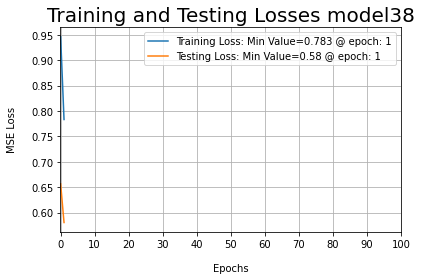

<Figure size 640x480 with 0 Axes>

 Epoch:2 Traj:39  Time Elapsed: 0:01:15
 Saving model 

Creation of the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder failed
Save path = /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder/model_params38_v2.pt

 Average Loss
0.7120191263733432

 Average Test Loss
0.5774204470799305 

Difference Between Training and Testing Losses
-0.13459867929341274 

Successfully created the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/model38_v2/ 
Done


<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

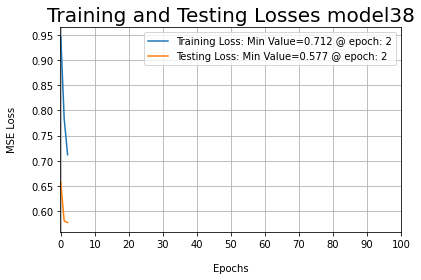

<Figure size 640x480 with 0 Axes>

 Epoch:3 Traj:39  Time Elapsed: 0:01:42
 Saving model 

Creation of the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder failed
Save path = /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder/model_params38_v3.pt

 Average Loss
0.6863452915102244

 Average Test Loss
0.5521174044231885 

Difference Between Training and Testing Losses
-0.13422788708703592 

Successfully created the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/model38_v3/ 
Done


<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

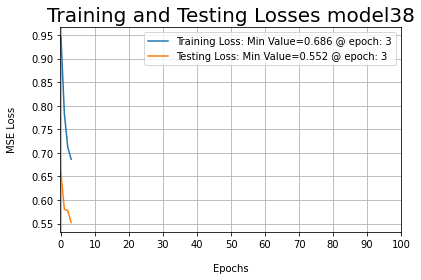

<Figure size 640x480 with 0 Axes>

 Epoch:4 Traj:39  Time Elapsed: 0:02:10
 Saving model 

Creation of the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder failed
Save path = /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder/model_params38_v4.pt

 Average Loss
0.6697066348977387

 Average Test Loss
0.5397356267203577 

Difference Between Training and Testing Losses
-0.12997100817738105 

Successfully created the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/model38_v4/ 
Done


<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

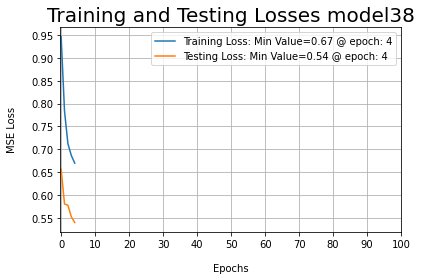

<Figure size 640x480 with 0 Axes>

Epoch: 5 Traj:0 Time Elapsed: 0:02:18 train loss: 0.08669655211269855 test loss: 0.30709269270300865
Epoch: 5 Traj:1 Time Elapsed: 0:02:19 train loss: 2.11093807220459 test loss: 0.17386106587946415
Epoch: 5 Traj:2 Time Elapsed: 0:02:19 train loss: 1.441639307886362 test loss: 0.9597266912460327
Epoch: 5 Traj:3 Time Elapsed: 0:02:20 train loss: 0.5124686844646931 test loss: 0.3195034861564636
Epoch: 5 Traj:4 Time Elapsed: 0:02:20 train loss: 0.08006254956126213 test loss: 0.5375971496105194
Epoch: 5 Traj:5 Time Elapsed: 0:02:21 train loss: 2.465187292546034 test loss: 0.30242177844047546
Epoch: 5 Traj:6 Time Elapsed: 0:02:21 train loss: 1.2403177917003632 test loss: 0.911038763821125
Epoch: 5 Traj:7 Time Elapsed: 0:02:22 train loss: 0.3955739513039589 test loss: 0.23259937390685081
Epoch: 5 Traj:8 Time Elapsed: 0:02:22 train loss: 0.7021532952785492 test loss: 0.8113477379083633
Epoch: 5 Traj:9 Time Elapsed: 0:02:23 train loss: 1.9050589203834534 test loss: 0.1792502161115408
Epoch: 5 

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

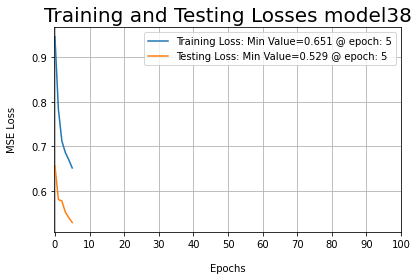

<Figure size 640x480 with 0 Axes>

 Epoch:6 Traj:39  Time Elapsed: 0:03:05
 Saving model 

Creation of the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder failed
Save path = /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder/model_params38_v6.pt

 Average Loss
0.6315037074266001

 Average Test Loss
0.5193789175187703 

Difference Between Training and Testing Losses
-0.11212478990782981 

Successfully created the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/model38_v6/ 
Done


<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

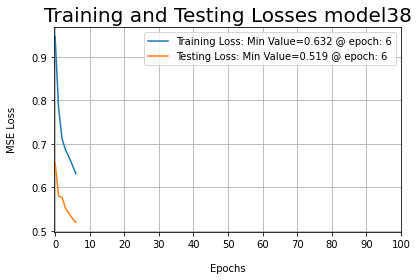

<Figure size 640x480 with 0 Axes>

 Epoch:7 Traj:39  Time Elapsed: 0:03:32
 Saving model 

Creation of the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder failed
Save path = /content/drive/My Drive/PhD/PhD/lstm3/model38/params_folder/model_params38_v7.pt

 Average Loss
0.6203172612702474

 Average Test Loss
0.5149258020450361 

Difference Between Training and Testing Losses
-0.10539145922521131 

Successfully created the directory /content/drive/My Drive/PhD/PhD/lstm3/model38/model38_v7/ 
Done


<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

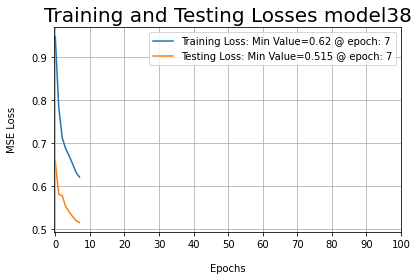

<Figure size 640x480 with 0 Axes>

 Epoch:8 Traj:17  Time Elapsed: 0:03:49

In [ ]:
%%time

lstm_layers = get_lstm_layers()
seq_length = get_seq_length() # when using zero padding, this seq_length is a bit redundent but still has to match the zero's size.

model = ForcePredictor(
      n_features=get_features(), 
      n_hidden= get_hidden(), #32, #64
      seq_len=seq_length, 
      n_layers=lstm_layers
    )

train_model(model)
## starting weight[0] should be -0.0306 assuming we're using 2 LSTM layers and 1 FC layer.

# MAE, Std-Dev and Max Values Plot
---
This code looks at all the metrics collected and plots the results for easy reference. 
<br>
This removes the need to go through each model's testing trajectories looking for the best fitting model.

---

In [ ]:
def find_file(mod_dir):

    file_path = get_path()
    
    means = []
    std_dev = []
    max = []
    PATH = file_path + "/*/*.csv"
    print(mod_dir)
    print(PATH)
    for file in glob.glob(PATH):
        w = pd.read_csv(file, low_memory=False)
        x = w.iloc[-3,1]
        y = w.iloc[-2,1]
        z = w.iloc[-1,1]
        
        means.append(x)
        std_dev.append(y)
        max.append(z)
    min_means = round(min(means),1), ' @ epoch: ', np.argmin(means)
    min_std_dev = round(min(std_dev),1), ' @ epoch: ', np.argmin(std_dev)
    min_max = round(min(max),1), ' @ epoch: ', np.argmin(max)
    return means, std_dev, max, min_means, min_std_dev, min_max
    


In [ ]:
model_num = model_number()

means, std_dev, max, min_mean, min_std_dev, min_max = find_file(f'model{model_num}')

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k');
figure(figsize=(20,4));
fig = plt.figure();
plt.plot(means, label=f'MAE: Min Value={min_mean[0]}{min_mean[1]}{min_mean[2]}');
plt.plot(std_dev, label=f'std Dev: Min Value={min_std_dev[0]}{min_std_dev[1]}{min_std_dev[2]}');
plt.plot(max, label=f'Max Values: Min Value={min_max[0]}{min_max[1]}{min_max[2]}');
plt.xlabel("Epochs", labelpad=14);
plt.ylabel("Error (N)", labelpad=14);
plt.title(f"Testing Error {model_dir}", fontsize=20);
#tick_labels = [i*10 for i in range(20)];
plt.xticks(np.arange(0,101, 10));
plt.grid(True);
plt.legend(loc=2, prop={'size': 8})
plt.tight_layout();
plt.show()


In [ ]:
path = get_path()
pdf = PdfPages(path + "/error.pdf")

# save the current figure
pdf.savefig(fig);
# destroy the current figure
plt.clf()
# close the object
pdf.close()
